![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Playing GridWorld with Reinforcement Learning (Policy Gradients with REINFORCE)

In this project we'll teach a neural network to navigate through a dangerous grid world.

![](http://i.imgur.com/XNGB7sr.gif)

Training uses [policy gradients](http://www.scholarpedia.org/article/Policy_gradient_methods) via the REINFORCE algorithm and a simplified Actor-Critic method. A single network calculates both a policy to choose the next action (the actor) and an estimated value of the current state (the critic). Rewards are propagated through the graph with PyTorch's [`reinforce` method](http://pytorch.org/docs/autograd.html?highlight=reinforce#torch.autograd.Variable.reinforce).

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
* [Scholarpedia article on policy gradient methods](http://www.scholarpedia.org/article/Policy_gradient_methods)
* [A Lecture from David Silver (of UCL, DeepMind) on policy gradients](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
* [The REINFORCE PyTorch example this tutorial is based on](https://github.com/pytorch/examples/tree/master/reinforcement_learning)


## Requirements

The main requirements are PyTorch (of course), and numpy, matplotlib, and iPython for animating the states.

In [39]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
%pylab inline

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

from helpers import *

Populating the interactive namespace from numpy and matplotlib


## The Grid World, Agent and Environment

First we'll build the training environment, which is a simple square grid world with various rewards and a goal. If you're just interested in the training code, skip down to [building the actor-critic network](#Actor-Critic-network)

### The Grid

The **Grid** class keeps track of the grid world: a 2d array of empty squares, plants, and the goal.

![](https://i.imgur.com/kss8W95.png)

Plants are randomly placed values from -1 to 0.5 (mostly poisonous) and if the agent lands on one, that value is added to the agent's health. The agent's goal is to reach the goal square, placed in one of the corners. As the agent moves around it gradually loses health so it has to move with purpose.

The agent can see a surrounding area `VISIBLE_RADIUS` squares out from its position, so the edges of the grid are padded by that much with negative values. If the agent "falls off the edge" it dies instantly.

In [40]:
MIN_PLANT_VALUE = -1
MAX_PLANT_VALUE = 0.5
GOAL_VALUE = 10
EDGE_VALUE = -10
VISIBLE_RADIUS = 1

class Grid():
    def __init__(self, grid_size=8, n_plants=15):
        self.grid_size = grid_size
        self.n_plants = n_plants
        
    def reset(self):
        padded_size = self.grid_size + 2 * VISIBLE_RADIUS
        self.grid = np.zeros((padded_size, padded_size)) # Padding for edges
        
        # Edges
        self.grid[0:VISIBLE_RADIUS, :] = EDGE_VALUE
        self.grid[-1*VISIBLE_RADIUS:, :] = EDGE_VALUE
        self.grid[:, 0:VISIBLE_RADIUS] = EDGE_VALUE
        self.grid[:, -1*VISIBLE_RADIUS:] = EDGE_VALUE
        
        # Randomly placed plants
        for i in range(self.n_plants):
            plant_value = random.random() * (MAX_PLANT_VALUE - MIN_PLANT_VALUE) + MIN_PLANT_VALUE
            ry = random.randint(0, self.grid_size-1) + VISIBLE_RADIUS
            rx = random.randint(0, self.grid_size-1) + VISIBLE_RADIUS
            self.grid[ry, rx] = plant_value
 
        # Goal in one of the corners
        S = VISIBLE_RADIUS
        E = self.grid_size + VISIBLE_RADIUS - 1
        gps = [(E, E), (S, E), (E, S), (S, S)]
        gp = gps[random.randint(0, len(gps)-1)]
        self.grid[gp] = GOAL_VALUE
    
    def visible(self, pos):
        y, x = pos
        return self.grid[y-VISIBLE_RADIUS:y+VISIBLE_RADIUS+1, x-VISIBLE_RADIUS:x+VISIBLE_RADIUS+1]

### The Agent

The **Agent** has a current position and a health. All this class does is update the position based on an action (up, right, down or left) and decrement a small `STEP_VALUE` at every time step, so that it eventually starves if it doesn't reach the goal.

The world based effects on the agent's health are handled by the Environment below.

In [41]:
START_HEALTH = 1
STEP_VALUE = -0.02

class Agent:
    def reset(self):
        self.health = START_HEALTH

    def act(self, action):
        # Move according to action: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        y, x = self.pos
        if action == 0: y -= 1
        elif action == 1: x += 1
        elif action == 2: y += 1
        elif action == 3: x -= 1
        self.pos = (int(y), int(x))
        self.health += STEP_VALUE # Gradually getting hungrier

SyntaxError: can't assign to function call (<ipython-input-41-8e2bb91f54ba>, line 10)

### The Environment

The **Environment** encapsulates the Grid and Agent, and handles the bulk of the logic of assigning rewards when the agent acts. If an agent lands on a plant or goal or edge, its health is updated accordingly. Plants are removed from the grid (set to 0) when "eaten" by the agent. Every time step there is also a slight negative health penalty so that the agent must keep finding plants or reach the goal to survive.

The Environment's main function is `step(action)` &rarr; `(state, reward, done)`, which updates the world state with a chosen action and returns the resulting state, and also returns a reward and whether the episode is done. The state it returns is what the agent will use to make its action predictions, which in this case is the visible grid area (flattened into one dimension) and the current agent health (to give it some "self awareness").

The episode is considered done if won or lost - won if the agent reaches the goal (`agent.health >= GOAL_VALUE`) and lost if the agent dies from falling off the edge, eating too many poisonous plants, or getting too hungry (`agent.health <= 0`).

In this experiment the environment only returns a single reward at the end of the episode (to make it more challenging). Values from plants and the step penalty are implicit - they might cause the agent to live longer or die sooner, but they aren't included in the final reward.

The Environment also keeps track of the grid and agent states for each step of an episode, for visualization.

In [36]:
class Environment:
    def __init__(self):
        self.grid = Grid()
        self.agent = Agent()

    def reset(self):
        """Start a new episode by resetting grid and agent"""
        self.grid.reset()
        self.agent.reset()
        c = math.floor(self.grid.grid_size / 2)
        self.agent.pos = (c, c)
        
        self.t = 0
        self.history = []
        self.record_step()
        
        return self.visible_state

    def record_step(self):
        """Add the current state to history for display later"""
        grid = np.array(self.grid.grid)
        print self.agent.pos
        print self.agent.health
        
        grid[self.agent.pos] = int(self.agent.health) * 0.5 # Agent marker faded by health
        visible = np.array(self.grid.visible(self.agent.pos))
        self.history.append((grid, visible, self.agent.health))
        
    @property
    def visible_state(self):
        """Return the visible area surrounding the agent, and current agent health"""
        visible = self.grid.visible(self.agent.pos)
        y, x = self.agent.pos
        yp = (y - VISIBLE_RADIUS) / self.grid.grid_size
        xp = (x - VISIBLE_RADIUS) / self.grid.grid_size
        extras = [self.agent.health, yp, xp]
        return np.concatenate((visible.flatten(), extras), 0)
    
    def step(self, action):
        """Update state (grid and agent) based on an action"""
        self.agent.act(action)
        
        # Get reward from where agent landed, add to agent health
        value = self.grid.grid[self.agent.pos]
        self.grid.grid[self.agent.pos] = 0
        self.agent.health += value
        
        # Check if agent won (reached the goal) or lost (health reached 0)    
    def record_step(self):
        """Add the current state to history for display later"""
        grid = np.array(self.grid.grid)
        grid[self.agent.pos] = self.agent.health * 0.5 # Agent marker faded by health
        visible = np.array(self.grid.visible(self.agent.pos))
        self.history.append((grid, visible, self.agent.health))
        won = value == GOAL_VALUE
        lost = self.agent.health <= 0
        done = won or lost
        
        # Rewards at end of episode
        if won:
            reward = 1
        elif lost:
            reward = -1
        else:
            reward = 0 # Reward will only come at the end

        # Save in history
        self.record_step()
        
        return self.visible_state, reward, done

### Visualizing History

To visualize an episode the `animate(history)` function uses Matplotlib to plot the grid state and agent health over time, and turn the resulting frames into a GIF.

In [37]:
def animate(history):
    frames = len(history)
    print("Rendering %d frames..." % frames)
    fig = plt.figure(figsize=(6, 2))
    fig_grid = fig.add_subplot(121)
    fig_health = fig.add_subplot(243)
    fig_visible = fig.add_subplot(244)
    fig_health.set_autoscale_on(False)
    health_plot = np.zeros((frames, 1))

    def render_frame(i):
        grid, visible, health = history[i]
        # Render grid
        fig_grid.matshow(grid, vmin=-1, vmax=1, cmap='jet')
        fig_visible.matshow(visible, vmin=-1, vmax=1, cmap='jet')
        # Render health chart
        health_plot[i] = health
        fig_health.clear()
        fig_health.axis([0, frames, 0, 2])
        fig_health.plot(health_plot[:i + 1])

    anim = matplotlib.animation.FuncAnimation(
        fig, render_frame, frames=frames, interval=100
    )

    plt.close()
    display(HTML(anim.to_html5_video()))

### Testing the Environment

Let's test what we have so far with a quick simulation:

In [38]:
env = Environment()
env.reset()
print(env.visible_state)

done = False
while not done:
    _, _, done = env.step(2) # Down

animate(env.history)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Actor-Critic network

Value-based reinforcement learning methods like Q-Learning try to predict the expected reward of the next state(s) given an action. In contrast, a policy method tries to directly choose the best action given a state. Policy methods are conceptually simpler but training can be tricky - due to the high variance of rewards, it can easily become unstable or just plateau at a local minimum.

Combining a value estimation with the policy helps regularize training by establishing a "baseline" reward that learns alongside the actor. Subtracting a baseline value from the rewards essentially trains the actor to perform "better than expected".

In this case, both actor and critic (baseline) are combined into a single neural network with 5 outputs: the probabilities of the 4 possible actions, and an estimated value.

The input layer `inp` transforms the environment state, $(radius*2+1)^2$ squares plus the agent's health and position,  into an internal state. The output layer `out` transforms that internal state to probabilities of possible actions plus the estimated value.

In [16]:
class Policy(nn.Module):
    def __init__(self, hidden_size):
        super(Policy, self).__init__()
        
        visible_squares = (VISIBLE_RADIUS * 2 + 1) ** 2
        input_size = visible_squares + 1 + 2 # Plus agent health, y, x
        
        self.inp = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, 4 + 1, bias=False) # For both action and expected value

    def forward(self, x):
        x = x.view(1, -1)
        x = F.tanh(x) # Squash inputs
        x = F.relu(self.inp(x))
        x = self.out(x)
        
        # Split last five outputs into scores and value
        scores = x[:,:4]
        value = x[:,4]
        return scores, value

## Selecting actions

To select actions we treat the output of the policy as a multinomial distribution over actions, and sample from that to choose a single action. Thanks to the [REINFORCE](https://webdocs.cs.ualberta.ca/~sutton/williams-92.pdf) algorithm we can calculate gradients for discrete action samples by calling `action.reinforce(reward)` at the end of the episode.

To encourage exploration in early episodes, here's one weird trick: apply dropout to the action scores, before softmax. Randomly masking some scores will cause less likely scores to be chosen. The dropout percent gradually decreases from 30% to 5% over the first 200k episodes.

In [17]:
DROP_MAX = 0.3
DROP_MIN = 0.05
DROP_OVER = 200000

def select_action(e, state):
    drop = interpolate(e, DROP_MAX, DROP_MIN, DROP_OVER)
    
    state = Variable(torch.from_numpy(state).float())
    scores, value = policy(state) # Forward state through network
    scores = F.dropout(scores, drop, True) # Dropout for exploration
    scores = F.softmax(scores)
    action = scores.multinomial() # Sample an action

    return action, value

## Playing through an episode

A single episode is the agent moving through the environment from start to finish. We keep track of the chosen action and value outputs from the model, and resulting rewards to reinforce at the end of the episode.

In [18]:
def run_episode(e):
    state = env.reset()
    actions = []
    values = []
    rewards = []
    done = False

    while not done:
        action, value = select_action(e, state)
        state, reward, done = env.step(action.data[0, 0])
        actions.append(action)
        values.append(value)
        rewards.append(reward)

    return actions, values, rewards

## Using REINFORCE with a value baseline

The policy gradient method is similar to regular supervised learning, except we don't know the "correct" action for any given state. Plus we are only getting a single reward at the end of the episode. To give rewards to past actions we fake history by copying the final reward (and possibly intermediate rewards) back in time with a discount factor:

![](https://i.imgur.com/IoXMuCb.png)

Then for every time step, we use `action.reinforce(reward)` to encourage or discourage those actions.

We will use the value output of the network as a baseline, and use the difference of the reward and the baseline with `reinforce`. The value estimate itself is trained to be close to the actual reward with a MSE loss.

In [19]:
gamma = 0.9 # Discounted reward factor

mse = nn.MSELoss()

def finish_episode(e, actions, values, rewards):
    
    # Calculate discounted rewards, going backwards from end
    discounted_rewards = []
    R = 0
    for r in rewards[::-1]:
        R = r + gamma * R
        discounted_rewards.insert(0, R)
    discounted_rewards = torch.Tensor(discounted_rewards)

    # Use REINFORCE on chosen actions and associated discounted rewards
    value_loss = 0
    for action, value, reward in zip(actions, values, discounted_rewards):
        reward_diff = reward - value.data[0] # Treat critic value as baseline
        action.reinforce(reward_diff) # Try to perform better than baseline
        value_loss += mse(value, Variable(torch.Tensor([reward]))) # Compare with actual reward

    # Backpropagate
    optimizer.zero_grad()
    nodes = [value_loss] + actions
    gradients = [torch.ones(1)] + [None for _ in actions] # No gradients for reinforced values
    autograd.backward(nodes, gradients)
    optimizer.step()
    
    return discounted_rewards, value_loss

With everything in place we can define the training parameters and create the actual Environment and Policy instances. We'll also use a SlidingAverage helper to keep track of average rewards over time.

In [20]:
hidden_size = 50
learning_rate = 1e-4
weight_decay = 1e-5

log_every = 1000
render_every = 20000

env = Environment()
policy = Policy(hidden_size=hidden_size)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)#, weight_decay=weight_decay)

reward_avg = SlidingAverage('reward avg', steps=log_every)
value_avg = SlidingAverage('value avg', steps=log_every)


Finally, we run a bunch of episodes and wait for some results. The average final reward will help us track whether it's learning. This took about an hour on a 2.8GHz CPU to get some reasonable results.

In [21]:
e = 0

while reward_avg < 0.75:
    actions, values, rewards = run_episode(e)
    final_reward = rewards[-1]
    
    discounted_rewards, value_loss = finish_episode(e, actions, values, rewards)
    
    reward_avg.add(final_reward)
    value_avg.add(value_loss.data[0])
    
    if e % log_every == 0:
        print('[epoch=%d]' % e, reward_avg, value_avg)
    
    if e > 0 and e % render_every == 0:
        animate(env.history)
    
    e += 1

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

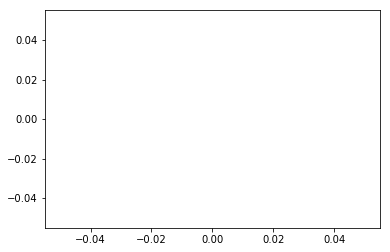

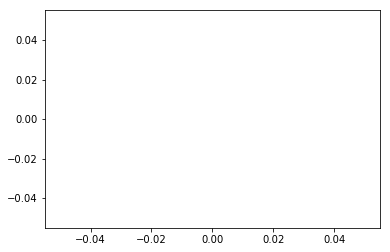

In [22]:
# Plot average reward and value loss
plt.plot(np.array(reward_avg.avgs))
plt.show()
plt.plot(np.array(value_avg.avgs))
plt.show()

As you can see from the shape of the rewards graph, training these kinds of networks is a rollercoaster of luck.

## Exercises

* Uncomment the line in the Environment class that returns a reward every step - the agent tends learn a bit quicker because the effects of eating plants are more immediately rewarded.
* Try with a bigger grid size, bigger visible area, bigger network, etc.
* Try with a recurrent network - it will train slower (in clock time) but often reaches higher values in fewer episodes.
* Observe the effects of different learning rates and gamma values.